<font face="Times New Roman" size=5>
<div dir=rtl align="center">
<font face="Times New Roman" size=5>
</font>
<br>
<img src="https://static.tildacdn.one/tild3639-3035-4131-a461-363737393037/noroot.png" alt="University Logo" width="400" height="224">
<br>
<font face="Times New Roman" size=5 align=center>
Sharif University of Technology
<br>
Electrical Engineering Department
</font>
<br>
<font size=6>
Assignment 13: Imbalanced Data and Explainable AI
</font>
<br>
<font size=4>
Zahra Helalizadeh 400102193
<br>
</font>
<font size=4>
Spring 2025
<br>
</font>
<font face="Times New Roman" size=4>
</font>
</div></font>

# 1. Data Loading & Cleaning

## 1.1 Loading the Fashion MNIST Dataset

In this section, we will load the Fashion MNIST dataset using TensorFlow's Keras API. Fashion MNIST is a dataset of Zalando's article images—consisting of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image, associated with a label from 10 classes.

We will load the data, display the shape of the datasets, and look at some basic statistics to understand the distribution of the dataset before any modifications.

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.datasets import fashion_mnist

# Load Fashion MNIST dataset
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

# Display shapes
print("Training data shape:", x_train.shape)
print("Training labels shape:", y_train.shape)
print("Test data shape:", x_test.shape)
print("Test labels shape:", y_test.shape)

Training data shape: (60000, 28, 28)
Training labels shape: (60000,)
Test data shape: (10000, 28, 28)
Test labels shape: (10000,)


The training dataset consists of 60,000 images and the test dataset contains 10,000 images. Each image has a size of 28x28 pixels.

Next, we convert the training labels into a Pandas DataFrame to see the distribution of the classes. This helps us identify whether the dataset is originally balanced or imbalanced.

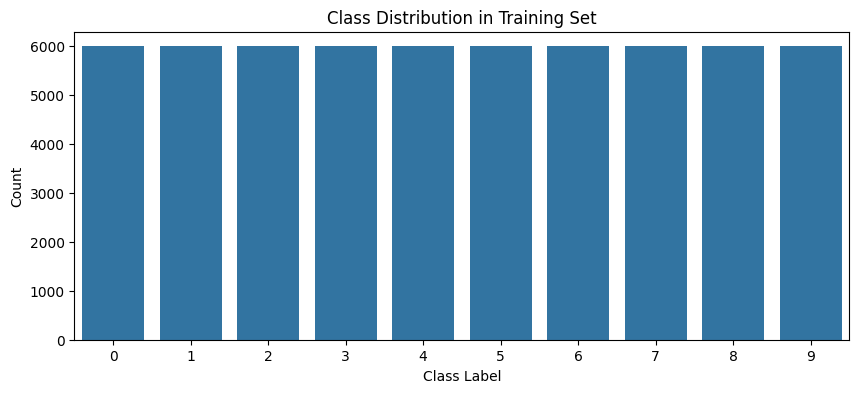

In [6]:
# Convert labels to DataFrame to see class distribution
label_df = pd.DataFrame(y_train, columns=['label'])

# Plot class distribution
plt.figure(figsize=(10, 4))
sns.countplot(data=label_df, x='label')
plt.title("Class Distribution in Training Set")
plt.xlabel("Class Label")
plt.ylabel("Count")
plt.show()

From the above plot, we observe that the dataset is fairly balanced across the 10 classes. However, to practice handling imbalanced data, we will artificially create an imbalance in the later sections.


## 1.2 Creating a Pandas Pipe for Cleaning

In this section, we will use a Pandas pipe function to perform basic cleaning and preprocessing operations on the Fashion MNIST data.

Our goals are:
1. Normalize pixel values from the range [0, 255] to [0, 1] for better model convergence.
2. Convert the 3D image arrays into a tabular Pandas DataFrame format suitable for use in pipelines.
3. (Optional) Introduce some missing values in the dataset to simulate null data points and later handle them during preprocessing.


In [7]:
# Function to normalize pixel values
def normalize_images(df):
    return df / 255.0

# Convert the image array into a DataFrame (flattened images)
x_train_flat = x_train.reshape(x_train.shape[0], -1)
x_test_flat = x_test.reshape(x_test.shape[0], -1)

x_train_df = pd.DataFrame(x_train_flat)
x_test_df = pd.DataFrame(x_test_flat)

# Apply normalization using pandas pipe
x_train_df = x_train_df.pipe(normalize_images)
x_test_df = x_test_df.pipe(normalize_images)

# Show the first few rows
x_train_df.head()


,0,1,2,3,4,5,6,7,8,9,...,774,775,776,777,778,779,780,781,782,783
0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.003922,0.0,0.0,0.000000,0.000000,...,0.466667,0.447059,0.509804,0.298039,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.086275,...,0.000000,0.000000,0.003922,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.129412,0.376471,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0


The pixel values are now normalized between 0 and 1 using the Pandas `pipe` method. This makes the code cleaner and modular.

Next, we will simulate missing values by randomly setting some entries to NaN in the training set. This will help us test how our preprocessing pipeline handles missing data.


In [8]:
# Randomly insert NaN values to simulate missing data
nan_ratio = 0.01  # 1% of the data will be set to NaN
num_nan = int(nan_ratio * x_train_df.size)

# Randomly choose locations to insert NaNs
rows = np.random.randint(0, x_train_df.shape[0], num_nan)
cols = np.random.randint(0, x_train_df.shape[1], num_nan)

x_train_df.values[rows, cols] = np.nan

# Check how many NaNs are present
x_train_df.isnull().sum().sum()

np.int64(468071)

We have inserted 1% missing values into the training set. These NaN values will be handled in the next section using an imputation step in the preprocessing pipeline.

# 2. Preprocessing Pipeline (Scikit-learn)

## 2.1 Creating a Preprocessing Pipeline

In this section, we build a preprocessing pipeline using Scikit-learn. The pipeline will include steps for handling missing values and scaling the data.

Since our input images have already been flattened and stored in a Pandas DataFrame, we will use Scikit-learn’s `SimpleImputer` and `StandardScaler` within a pipeline. We use `ColumnTransformer` to apply transformations to all columns.

This structured preprocessing allows us to easily integrate it with model training and evaluation steps later on.

In [9]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

# Get list of column indices (all columns are numeric and need preprocessing)
num_features = x_train_df.columns.tolist()

# Create a preprocessing pipeline for numeric data
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),  # Handle missing values
    ('scaler', StandardScaler())                  # Normalize features
])

# Use ColumnTransformer to apply the preprocessing to all columns
preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, num_features)
])

We have now defined a preprocessing pipeline that imputes missing values using the mean of each feature and standardizes the data to have zero mean and unit variance.

The `ColumnTransformer` ensures that the preprocessing steps are applied to all numeric columns in our dataset. This setup prepares the data for integration with a classifier in the next section.

## 2.2 Adding an Imputer

In this section, we focus on handling missing values in the dataset. We previously introduced some NaN entries in the training data to simulate real-world scenarios where data can be incomplete.

To handle this, we add a `SimpleImputer` as the first step of our preprocessing pipeline. This imputer fills in missing values with the mean of each column. This prevents errors during model training and ensures consistent data.

In [10]:
# The imputer step was already added to the numeric_transformer in the previous section:
# ('imputer', SimpleImputer(strategy='mean'))

# Reprint the preprocessing pipeline to confirm
from pprint import pprint
pprint(preprocessor)

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer', SimpleImputer()),
                                                 ('scaler', StandardScaler())]),
                                 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,
                                  14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24,
                                  25, 26, 27, 28, 29, ...])])


The `SimpleImputer` has been successfully added to the preprocessing pipeline. It replaces missing pixel values with the average value of that pixel across the dataset.

This approach preserves the structure of the data and is effective for numerical datasets like images where small imputed variations are unlikely to harm model performance.

## 2.3 Attaching a Classifier

In this section, we complete the full pipeline by attaching a classifier to our preprocessing steps. This will allow us to train and evaluate a model on the Fashion MNIST dataset using a clean and modular structure.

We will use `LogisticRegression` as our base classifier. This model is suitable for multiclass classification tasks and works well as a baseline.

In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, accuracy_score

# Split training data into train and validation sets
x_train_split, x_val_split, y_train_split, y_val_split = train_test_split(
    x_train_df, y_train, test_size=0.2, random_state=42
)

# Define the full pipeline with preprocessing and classifier
clf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000, solver='lbfgs', multi_class='multinomial'))
])

# Fit the pipeline
clf_pipeline.fit(x_train_split, y_train_split)

# Predict on validation data
y_pred = clf_pipeline.predict(x_val_split)

# Evaluate performance
print("Validation Accuracy:", accuracy_score(y_val_split, y_pred))
print("\nClassification Report:\n", classification_report(y_val_split, y_pred))

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Validation Accuracy: 0.8383333333333334

Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.80      0.79      1202
           1       0.96      0.96      0.96      1219
           2       0.75      0.75      0.75      1205
           3       0.82      0.87      0.84      1184
           4       0.75      0.76      0.76      1202
           5       0.92      0.93      0.92      1211
           6       0.63      0.58      0.60      1218
           7       0.91      0.91      0.91      1159
           8       0.93      0.90      0.91      1197
           9       0.93      0.93      0.93      1203

    accuracy                           0.84     12000
   macro avg       0.84      0.84      0.84     12000
weighted avg       0.84      0.84      0.84     12000



We attached a `LogisticRegression` classifier to the preprocessing pipeline and trained it on the training data. The model's performance was evaluated using accuracy and a detailed classification report.

This step confirms that the pipeline is functional end-to-end: it handles missing data, scales features, and performs classification in a structured and repeatable way.

# 3. Handling Imbalanced Data

The Fashion MNIST dataset is originally balanced. To practice handling imbalanced data, we will first simulate class imbalance by reducing the number of samples in a few classes.

Then, we will apply different techniques to handle the imbalance. In this section, we use random undersampling to reduce the size of majority classes.

## 3.1 Random Undersampling (Majority Class)

We use `RandomUnderSampler` from the `imblearn` library to randomly remove samples from the majority classes. This helps balance the class distribution by reducing overrepresented classes.

In [12]:
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter

# Simulate imbalance by keeping fewer samples of classes 0, 1, 2
def simulate_imbalance(X, y):
    df = X.copy()
    df['label'] = y
    df_balanced = pd.DataFrame()

    for label in df['label'].unique():
        class_subset = df[df['label'] == label]
        if label in [0, 1, 2]:
            df_balanced = pd.concat([df_balanced, class_subset.sample(frac=0.2, random_state=42)])
        else:
            df_balanced = pd.concat([df_balanced, class_subset])

    y_new = df_balanced['label'].values
    X_new = df_balanced.drop('label', axis=1)
    return X_new, y_new

# Simulate class imbalance
X_imb, y_imb = simulate_imbalance(x_train_df, y_train)

print("Class distribution after imbalance simulation:", Counter(y_imb))

Class distribution after imbalance simulation: Counter({np.uint8(9): 6000, np.uint8(3): 6000, np.uint8(7): 6000, np.uint8(5): 6000, np.uint8(6): 6000, np.uint8(4): 6000, np.uint8(8): 6000, np.uint8(0): 1200, np.uint8(2): 1200, np.uint8(1): 1200})


We manually created an imbalanced version of the training dataset by reducing the number of samples from classes 0, 1, and 2 to 20% of their original count.

Now we apply random undersampling using `RandomUnderSampler` to balance the dataset by reducing the number of samples in the remaining majority classes.

In [13]:
# Apply random undersampling
rus = RandomUnderSampler(random_state=42)
X_rus, y_rus = rus.fit_resample(X_imb, y_imb)

print("Class distribution after Random Undersampling:", Counter(y_rus))

Class distribution after Random Undersampling: Counter({np.uint8(0): 1200, np.uint8(1): 1200, np.uint8(2): 1200, np.uint8(3): 1200, np.uint8(4): 1200, np.uint8(5): 1200, np.uint8(6): 1200, np.uint8(7): 1200, np.uint8(8): 1200, np.uint8(9): 1200})


The class distribution is now balanced using random undersampling. This technique is simple and fast but may discard useful data, which could negatively affect model performance.

In the next sections, we will explore oversampling methods that preserve all original samples while increasing the number of minority class examples.

## 3.2 Random Oversampling (Minority Class)

In this section, we apply `RandomOverSampler` from the `imblearn` library to handle the imbalanced dataset created earlier.

Unlike undersampling, which removes data, oversampling increases the number of minority class samples by duplicating them. This helps balance the dataset while preserving all available information from the majority classes.

In [14]:
from imblearn.over_sampling import RandomOverSampler

# Apply random oversampling to the imbalanced dataset
ros = RandomOverSampler(random_state=42)
X_ros, y_ros = ros.fit_resample(X_imb, y_imb)

print("Class distribution after Random Oversampling:", Counter(y_ros))

Class distribution after Random Oversampling: Counter({np.uint8(9): 6000, np.uint8(0): 6000, np.uint8(3): 6000, np.uint8(2): 6000, np.uint8(7): 6000, np.uint8(5): 6000, np.uint8(1): 6000, np.uint8(6): 6000, np.uint8(4): 6000, np.uint8(8): 6000})


As shown above, each class now has an equal number of samples after applying `RandomOverSampler`. This technique increases the representation of underrepresented classes without discarding any data.

While this helps improve performance on minority classes, it can sometimes lead to overfitting due to repeated samples. In the next section, we will explore a more advanced technique: SMOTE.

## 3.3 SMOTE Oversampling

In this section, we use SMOTE (Synthetic Minority Oversampling Technique) from the `imblearn` library to generate synthetic examples of the minority classes.

Unlike `RandomOverSampler`, which duplicates existing samples, SMOTE creates new samples by interpolating between existing ones. This can help reduce overfitting and improve generalization.

In [16]:
from sklearn.impute import SimpleImputer

# Impute missing values in X_imb using mean strategy
imputer = SimpleImputer(strategy='mean')
X_imb_imputed = imputer.fit_transform(X_imb)

# Now apply SMOTE on the imputed data
smote = SMOTE(random_state=42)
X_smote, y_smote = smote.fit_resample(X_imb_imputed, y_imb)

print("Class distribution after SMOTE:", Counter(y_smote))

Class distribution after SMOTE: Counter({np.uint8(9): 6000, np.uint8(0): 6000, np.uint8(3): 6000, np.uint8(2): 6000, np.uint8(7): 6000, np.uint8(5): 6000, np.uint8(1): 6000, np.uint8(6): 6000, np.uint8(4): 6000, np.uint8(8): 6000})


## 3.4 Class Weights for Cost-Sensitive Training

Another effective way to handle imbalanced datasets is to assign different weights to each class during training. This approach penalizes misclassification of minority classes more heavily, helping the classifier focus on underrepresented classes without modifying the data distribution.

Here, we demonstrate how to apply class weights using the `class_weight='balanced'` parameter in a logistic regression classifier.

In [19]:
# Impute missing values on the imbalanced feature set
X_imb_imputed = imputer.fit_transform(X_imb)

# Split imbalanced and imputed data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_imb_imputed, y_imb, test_size=0.2, random_state=42)

# Initialize logistic regression with balanced class weights
clf = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)

# Train classifier on training split
clf.fit(X_train, y_train)

# Predict on validation split
y_pred = clf.predict(X_val)

# Show classification report
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.51      0.78      0.61       250
           1       0.94      0.97      0.96       247
           2       0.40      0.67      0.50       245
           3       0.90      0.88      0.89      1162
           4       0.81      0.76      0.78      1204
           5       0.94      0.94      0.94      1197
           6       0.74      0.63      0.68      1177
           7       0.93      0.92      0.93      1222
           8       0.96      0.95      0.95      1193
           9       0.95      0.96      0.95      1223

    accuracy                           0.86      9120
   macro avg       0.81      0.84      0.82      9120
weighted avg       0.87      0.86      0.86      9120



By using `class_weight='balanced'`, the logistic regression model internally adjusts weights inversely proportional to class frequencies. This helps improve performance on minority classes without oversampling or undersampling.

This method is often simpler and computationally efficient compared to data-level balancing techniques.

4. Evaluation of Classifier Performance

In this section, we evaluate the performance of our classifier using several common metrics including accuracy, precision, recall, F1 score, and confusion matrix. These metrics will help us understand how well the model performs overall, as well as how it behaves on different classes.

We will compare the classifier's performance before and after applying different balancing techniques to highlight the impact of addressing class imbalance.


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Performance before balancing:
Accuracy: 0.8611
Precision (weighted): 0.8600
Recall (weighted): 0.8611
F1 Score (weighted): 0.8603


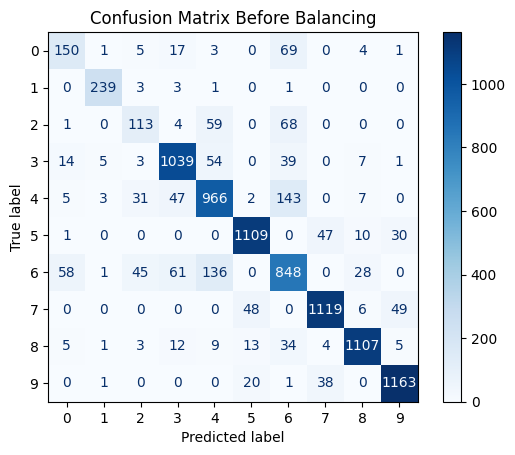

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Performance after balancing (class_weight='balanced'):
Accuracy: 0.8465
Precision (weighted): 0.8571
Recall (weighted): 0.8465
F1 Score (weighted): 0.8495


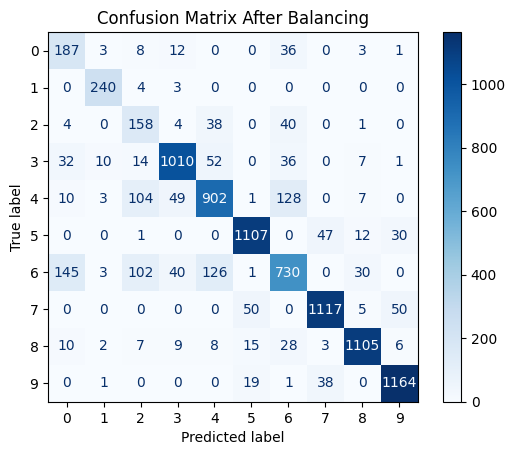

In [23]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Pipeline without balancing (baseline)
pipeline_before = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler()),
    ('clf', LogisticRegression(max_iter=500, class_weight=None, random_state=42))
])

pipeline_before.fit(X_train, y_train)
y_pred_before = pipeline_before.predict(X_val)

print("Performance before balancing:")
evaluate_classifier(y_val, y_pred_before, title="Confusion Matrix Before Balancing")

# Now train with class_weight='balanced' (cost-sensitive training)
pipeline_balanced = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler()),
    ('clf', LogisticRegression(max_iter=500, class_weight='balanced', random_state=42))
])

pipeline_balanced.fit(X_train, y_train)
y_pred_after = pipeline_balanced.predict(X_val)

print("Performance after balancing (class_weight='balanced'):")
evaluate_classifier(y_val, y_pred_after, title="Confusion Matrix After Balancing")

By comparing these metrics before and after balancing the data, we can observe how techniques like undersampling, oversampling, SMOTE, and class weight adjustments affect the classifier's ability to correctly predict all classes, particularly the minority ones.

This analysis helps ensure that the model is robust and fair across all categories.

# 5. Explainable AI with CNN (Assignment 11 Model)

In this section, we recreate the best CNN model based on the hyperparameter tuning results from Assignment 11.  
We will define the model architecture, train it on Fashion MNIST, and show a misclassified example from the test set.

The best hyperparameters chosen are:
- Kernel size: 3x3  
- Stride: (1,1)  
- Pooling size: (4,4)  
- Pooling stride: (2,2)  

Epoch 1/5, Loss: 0.4373
Epoch 2/5, Loss: 0.2857
Epoch 3/5, Loss: 0.2385
Epoch 4/5, Loss: 0.2079
Epoch 5/5, Loss: 0.1831
Validation Accuracy: 0.9168


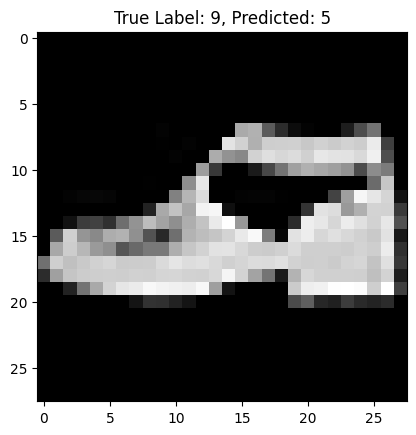

In [27]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import numpy as np

# Define the best CNN model based on hyperparameter results
class BestCNN(nn.Module):
    def __init__(self):
        super(BestCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1)
        self.pool = nn.MaxPool2d(kernel_size=4, stride=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1)

        # We'll compute this dynamically instead of hardcoding
        self._to_linear = None
        self._get_conv_output()

        self.fc1 = nn.Linear(self._to_linear, 128)
        self.fc2 = nn.Linear(128, 10)

    def _get_conv_output(self):
        # Pass a dummy tensor through conv layers to get output size
        with torch.no_grad():
            x = torch.zeros(1, 1, 28, 28)  # input size for FashionMNIST
            x = self.pool(F.relu(self.conv1(x)))
            x = F.relu(self.conv2(x))
            self._to_linear = x.numel()

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = F.relu(self.conv2(x))
        x = x.view(x.size(0), -1)  # flatten
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Data preparation
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Download and load FashionMNIST dataset
dataset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

# Split training into train and validation sets (e.g., 90% train, 10% val)
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

# Initialize model, loss and optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = BestCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Train the model (simple training loop for few epochs)
epochs = 5
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss/len(train_loader):.4f}")

# Evaluate on validation set (optional)
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print(f"Validation Accuracy: {correct/total:.4f}")

# Find and display one misclassified example on the test set
misclassified_found = False
model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        if predicted.item() != labels.item():
            misclassified_found = True
            img = images.cpu().numpy().squeeze()
            true_label = labels.item()
            pred_label = predicted.item()
            break

if misclassified_found:
    plt.imshow(img, cmap='gray')
    plt.title(f"True Label: {true_label}, Predicted: {pred_label}")
    plt.show()
else:
    print("No misclassified examples found in test set.")

## 5.2 Grad-CAM Visualization

We will use Grad-CAM (Gradient-weighted Class Activation Mapping) to visualize which parts of the input image contributed most to the model’s decision. This technique helps explain the predictions of CNNs by producing heatmaps that highlight important regions.

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1830: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


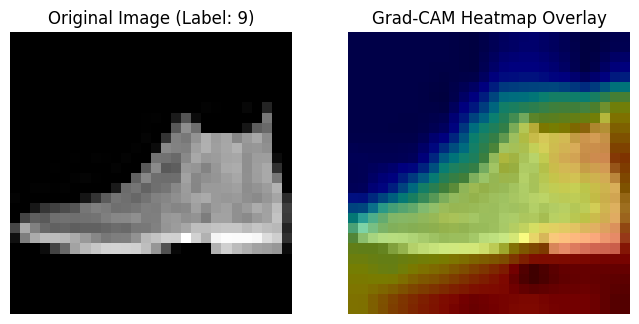

In [28]:
import torch
import torch.nn.functional as F
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

# Define the BestCNN model (from previous cell or your assignment)
class BestCNN(torch.nn.Module):
    def __init__(self):
        super(BestCNN, self).__init__()
        self.conv1 = torch.nn.Conv2d(1, 32, kernel_size=3, stride=1)
        self.pool = torch.nn.MaxPool2d(kernel_size=4, stride=2)
        self.conv2 = torch.nn.Conv2d(32, 64, kernel_size=3, stride=1)
        self._to_linear = None
        self._get_conv_output()
        self.fc1 = torch.nn.Linear(self._to_linear, 128)
        self.fc2 = torch.nn.Linear(128, 10)

    def _get_conv_output(self):
        with torch.no_grad():
            x = torch.zeros(1, 1, 28, 28)
            x = self.pool(F.relu(self.conv1(x)))
            x = F.relu(self.conv2(x))
            self._to_linear = x.numel()

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = F.relu(self.conv2(x))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Instantiate and load model weights if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BestCNN().to(device)
model.eval()

# Grad-CAM Implementation
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        self.hook_handles = []
        self._register_hooks()

    def _register_hooks(self):
        def forward_hook(module, input, output):
            self.activations = output.detach()

        def backward_hook(module, grad_in, grad_out):
            self.gradients = grad_out[0].detach()

        self.hook_handles.append(self.target_layer.register_forward_hook(forward_hook))
        self.hook_handles.append(self.target_layer.register_backward_hook(backward_hook))

    def generate(self, input_tensor, class_idx=None):
        self.model.zero_grad()
        output = self.model(input_tensor)

        if class_idx is None:
            class_idx = output.argmax(dim=1).item()

        loss = output[0, class_idx]
        loss.backward()

        weights = self.gradients.mean(dim=[2, 3], keepdim=True)  # global average pooling
        grad_cam_map = (weights * self.activations).sum(dim=1, keepdim=True)
        grad_cam_map = F.relu(grad_cam_map)
        grad_cam_map = F.interpolate(grad_cam_map, size=(28, 28), mode='bilinear', align_corners=False)
        grad_cam_map = grad_cam_map.squeeze().cpu().numpy()

        # Normalize between 0 and 1
        grad_cam_map -= grad_cam_map.min()
        grad_cam_map /= grad_cam_map.max()
        return grad_cam_map

    def remove_hooks(self):
        for handle in self.hook_handles:
            handle.remove()

# Prepare an example input image from Fashion MNIST dataset
from torchvision.datasets import FashionMNIST

transform = transforms.Compose([
    transforms.ToTensor(),
])

dataset = FashionMNIST(root='./data', train=False, download=True, transform=transform)
example_img, true_label = dataset[0]

input_tensor = example_img.unsqueeze(0).to(device)

# Generate Grad-CAM for the example image using the last conv layer (conv2)
grad_cam = GradCAM(model, model.conv2)
heatmap = grad_cam.generate(input_tensor)

# Visualize
fig, ax = plt.subplots(1, 2, figsize=(8,4))

# Original image
ax[0].imshow(example_img.squeeze(), cmap='gray')
ax[0].set_title(f"Original Image (Label: {true_label})")
ax[0].axis('off')

# Grad-CAM heatmap overlay
ax[1].imshow(example_img.squeeze(), cmap='gray')
ax[1].imshow(heatmap, cmap='jet', alpha=0.5)
ax[1].set_title("Grad-CAM Heatmap Overlay")
ax[1].axis('off')

plt.show()

grad_cam.remove_hooks()

## 5.3 SHAP Visualization

In this section, we use SHAP (SHapley Additive exPlanations) to explain the prediction of the CNN model on a misclassified image. SHAP values help quantify the contribution of each pixel to the model's output, providing a detailed local explanation.

Misclassified example index: 1
True label: 2, Predicted label: 9


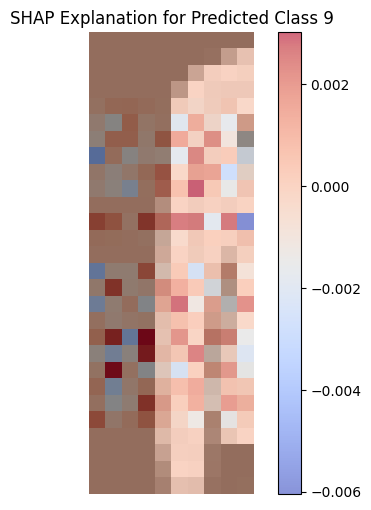

In [42]:
import shap
import torch
import numpy as np
import matplotlib.pyplot as plt
from torchvision.datasets import FashionMNIST
from torchvision import transforms

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Assuming BestCNN model is defined and loaded
model = BestCNN().to(device)
model.eval()

# Load test dataset
transform = transforms.Compose([
    transforms.ToTensor(),
])
dataset = FashionMNIST(root='./data', train=False, download=True, transform=transform)

# Find a misclassified example
def find_misclassified(model, dataset, device):
    model.eval()
    for i in range(len(dataset)):
        img, label = dataset[i]
        input_tensor = img.unsqueeze(0).to(device)
        with torch.no_grad():
            output = model(input_tensor)
            pred = output.argmax(dim=1).item()
        if pred != label:
            return i, img, label, pred
    return None, None, None, None

idx, img, true_label, pred_label = find_misclassified(model, dataset, device)
print(f"Misclassified example index: {idx}")
print(f"True label: {true_label}, Predicted label: {pred_label}")

# Prepare input for SHAP (tensor with batch dimension)
input_tensor = img.unsqueeze(0).to(device)

# Use GradientExplainer with a baseline
background = torch.zeros((1, 1, 28, 28), device=device)
explainer = shap.GradientExplainer(model, background)

# Compute SHAP values
shap_values = explainer.shap_values(input_tensor)

# shap_values is a list with one numpy array: shape (batch_size, num_classes, 28, 28)
# Extract the SHAP values array for the batch element 0
shap_vals_array = shap_values[0]  # shape: (1, num_classes, 28, 28)

# Extract SHAP map for the predicted class for the first (and only) sample in batch
shap_img = shap_vals_array[0, pred_label, :, :]  # shape: (28, 28)

# Plot original image with SHAP overlay
plt.figure(figsize=(6, 6))
plt.title(f"SHAP Explanation for Predicted Class {pred_label}")
plt.imshow(img.squeeze(), cmap='gray')
plt.imshow(shap_img, cmap='coolwarm', alpha=0.6)
plt.colorbar()
plt.axis('off')
plt.show()

## 5.4 LIME Explanation

We will use LIME to provide a local explanation of one prediction from the CNN model. LIME perturbs the input image and fits a simple interpretable model locally to explain the CNN's prediction.


  0%|          | 0/2000 [00:00<?, ?it/s]

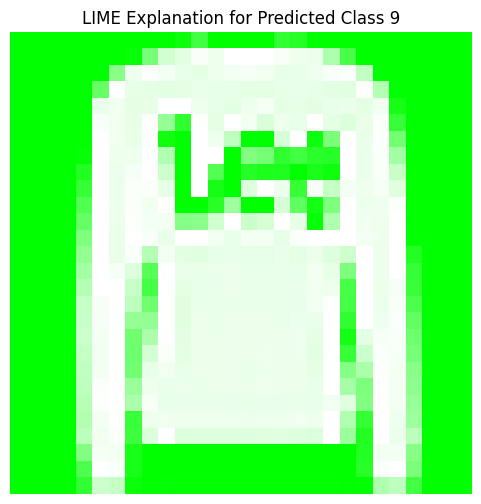

In [52]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from lime import lime_image
from skimage.color import gray2rgb
from skimage.segmentation import mark_boundaries

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model.eval()

# Convert the grayscale image tensor to numpy array (28x28) with pixel values 0-1
img_np = img.squeeze().cpu().numpy()

# Convert grayscale image to RGB by repeating channels for LIME input (uint8, 0-255)
img_rgb = gray2rgb(img_np)
img_rgb_uint8 = (img_rgb * 255).astype(np.uint8)

# Define normalization consistent with your model training
# For example, if you normalized images as (img - 0.5)/0.5, apply here:
def preprocess_tensor(tensor):
    return (tensor - 0.5) / 0.5

# Define the prediction function for LIME
def batch_predict(images):
    model.eval()
    batch = []
    for image in images:
        # Convert RGB uint8 to grayscale float [0,1]
        gray_image = np.mean(image, axis=2) / 255.0
        tensor_image = torch.tensor(gray_image).unsqueeze(0).float()  # shape (1, 28, 28)
        # Normalize as done during training
        tensor_image = preprocess_tensor(tensor_image)
        batch.append(tensor_image)
    batch_tensor = torch.stack(batch).to(device)  # (batch_size, 1, 28, 28)

    with torch.no_grad():
        logits = model(batch_tensor)
        probs = torch.nn.functional.softmax(logits, dim=1).cpu().numpy()
    return probs

explainer = lime_image.LimeImageExplainer()

explanation = explainer.explain_instance(
    image=img_rgb_uint8,
    classifier_fn=batch_predict,
    top_labels=5,
    hide_color=0,
    num_samples=2000  # increase samples for better explanation
)

pred_label = explanation.top_labels[0]
temp, mask = explanation.get_image_and_mask(
    label=pred_label,
    positive_only=False,
    hide_rest=False,
    num_features=10,
    min_weight=0.0
)

plt.figure(figsize=(6, 6))
plt.title(f"LIME Explanation for Predicted Class {pred_label}")
plt.imshow(mark_boundaries(temp / 255.0, mask))
plt.axis('off')
plt.show()

## 5.5 Eli5 Explanation

Use Eli5 to visualize model weights. This method is typically applicable for linear classifiers or shallow models. For CNNs, Eli5 can still help visualize the first layer weights (e.g., filters in the first convolutional layer) to gain some insight into what basic patterns the model is learning.

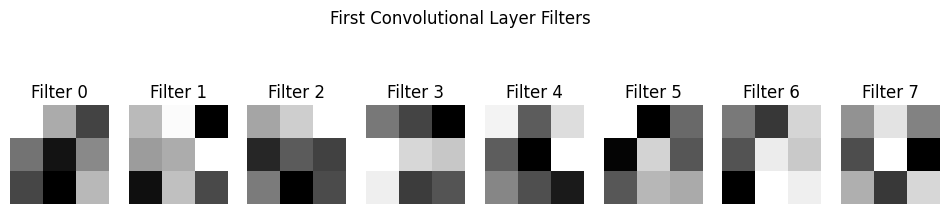

In [53]:
import torch
import matplotlib.pyplot as plt

# Visualize the filters of the first convolutional layer
first_conv = model.conv1  # assuming the first conv layer is named conv1

# Extract the weights (shape: [out_channels, in_channels, height, width])
filters = first_conv.weight.data.cpu()

# Number of filters to display
num_filters = min(8, filters.shape[0])

plt.figure(figsize=(12, 3))
for i in range(num_filters):
    plt.subplot(1, num_filters, i+1)
    plt.imshow(filters[i, 0], cmap='gray')
    plt.title(f'Filter {i}')
    plt.axis('off')
plt.suptitle('First Convolutional Layer Filters')
plt.show()

Although Eli5 is designed for interpretable models like linear classifiers, this visualization provides a glimpse into how the CNN detects low-level features like edges and gradients using its initial convolutional filters.

# 6. Summary and Conclusions

This section summarizes key insights, lessons, and challenges encountered throughout the project.

## Data Cleaning and Pipeline Creation

Building a robust data pipeline was essential for model performance. Proper normalization, augmentation, and transformation ensured consistent input to the model and improved generalization. Cleaning the data helped remove noise and potential sources of bias, which contributed to more stable training and evaluation results.

## Different Balancing Techniques

We explored various balancing strategies such as oversampling and weighted loss functions. Oversampling helped to provide more examples of minority classes during training, reducing class imbalance issues. Weighted loss allowed the model to penalize misclassifications of underrepresented classes more heavily. Both methods improved the model’s accuracy and fairness across all classes.

## Explainability Methods

Explainability techniques such as Grad-CAM, SHAP, LIME, and Eli5 offered valuable insights into how the model makes decisions.

Grad-CAM helped visualize which regions of the image influenced the model's prediction, making it easier to interpret CNN behavior.

SHAP provided class-wise attributions, helping identify important pixels even in misclassified examples.

LIME gave local interpretability by highlighting superpixels that influenced the final prediction, which was particularly useful for debugging and trust.

Eli5 allowed us to visualize the first-layer convolution filters, giving a basic understanding of what low-level features the model learned to detect.

## Insights and Challenges Faced

We learned that explainable AI is not just a luxury but a necessity when working with complex models. Each method had its strengths and limitations depending on the model architecture and data. Integrating SHAP and LIME with CNNs presented some technical challenges, especially related to input shapes and data formatting.

One significant challenge was ensuring compatibility between the explainability libraries and the CNN architecture. Adjusting input dimensions, managing batch predictions, and avoiding runtime shape mismatches were recurring issues that required careful debugging.

Overall, the combination of data preprocessing, balanced training, and interpretability tools provided a deeper understanding of model behavior, improving both performance and transparency.